# Project - Predicting House Sale Prices



## Introduction

### Preliminary

This Notebook is the conclusion of the **Linear Regression For Machine Learning** course from [dataquest.io](dataquest.io). It is a guided project whose aim is to use all the techniques and skills learnt during the course. We will be working here with a dataset on sold houses in Ames, Iowa. This dataset was originally compiled by Dean De Cock for the primary purpose of having a high quality dataset for regression. You can read more about his process and motivation [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) and download the dataset [here](https://dsserver-prod-resources-1.s3.amazonaws.com/235/AmesHousing.txt).

#### Blockquotes usage
> I am sometimes using blockquotes as this one, meaning that for the rest of the project I am quoting some elements given by dataquest. For the sake of simplicity and clarity, I estimated that they did not need any reformulation and were immediately usable and convenient for me and the reader.

### Context



The dataset is a text file : `AmesHousing.txt`, and contains 2930 rows.  
Each row in the dataset describes the properties of a single house as well as the amount it was sold for.
> Here some are some of the columns:
- Lot Area: Lot size in square feet.
- Overall Qual: Rates the overall material and finish of the house.
- Overall Cond: Rates the overall condition of the house.
- Year Built: Original construction date.
- Low Qual Fin SF: Low quality finished square feet (all floors).
- Full Bath: Full bathrooms above grade.
- Fireplaces: Number of fireplaces.


## Reading the Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

data = pd.read_csv("AmesHousing.txt", delimiter = "\t")
# reg = linear_model.LinearRegression()


### Initial functions pipeline

In [7]:
def transform_features(df):
    # will be modified later
    return df

def select_features(train):
    #will be modified later
    return train[['Gr Liv Area','SalePrice']]
    
def train_and_test_1(data):
    train = data[:1460]
    test = data[1460:]
    train = select_features(train)
    target = "SalePrice"
    features = train.columns.drop(target)
    lr = linear_model.LinearRegression() 
    fit = lr.fit(train[features],train["SalePrice"]) 
    test_predictions = lr.predict(test[features])
    test_mse = sklearn.metrics.mean_squared_error(test[target],test_predictions)
    test_rmse = np.sqrt(test_mse)
    return test_rmse
                                       
                                

In [8]:
train_and_test_1(data)

57088.251612639091

In [9]:
train = data[:1460]
train.shape

(1460, 82)

## Feature Engineering

Initially there are 1460 rows and 82 columns in our train data set. We are going to process and create new features what is also called ***feature engineering***. We will be determining for each column is some transformations are necessary which can lead to for instance :
- removing columns or rows with missing values
- removing features that we don't want to use in the model
- transforming features into the proper format
- creating new features by combining other features

Updating the `transform_features` function

In [10]:
def transform_features(data):
    df = data.copy()
    # useless columns for ML 
    useless = ["PID","Order"]
    df = df.drop(useless,axis=1)
    # data leakage columns
    leak = ["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"]
    df = df.drop(leak,axis=1)
    
    # columns correlated to others
    cor_cols =['Garage Cars', 'TotRms AbvGrd']
    df = df.drop(cor_cols,axis=1)
    
    # new feature  
    df["years_until_remod"] = df["Year Remod/Add"] - df['Year Built']
    # dropping with negative value
    df = df.drop(df[df["years_until_remod"]<0].index[0],axis=0)
    # drop the columns not used anymore
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    # dropping all columns with more than 5% missing values
    mv = df.isnull().sum()/1460
    cols_mv = mv[mv >= 0.05].index
    df = df.drop(cols_mv,axis =1)
    
    # dropping all text columns with one more missing values
    mask_text = df.select_dtypes(include=['object']).isnull().sum() > 0
    cols_text_mv = mask_text[mask_text == True].index
    df = df.drop(cols_text_mv,axis=1)
    
    
    #filling missing values for numerical columns
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    col_num_mv = num_missing[num_missing > 0].index
    df[col_num_mv] = df[col_num_mv].fillna(df[col_num_mv].mode().iloc[0])

    #scaling the values
    #df = (df - df.min()) / (df.max()- df.min())
    
    return df

def select_features(train):
    
    #turning text columns to category
    text_cols = train.select_dtypes(include=['object']).columns
    for col in text_cols:
        train[col] = train[col].astype('category')
    
    return train[['Gr Liv Area','SalePrice']]
    
def train_and_test(data):
    train = data[:1460]
    test = data[1460:]
    train = select_features(train)
    #numerical_train = train.select_dtypes(include=['integer', 'float'])
    target = "SalePrice"
    features = train.columns.drop(target)
    lr = linear_model.LinearRegression() 
    fit = lr.fit(train[features],train["SalePrice"]) 
    test_predictions = lr.predict(test[features])
    test_mse = sklearn.metrics.mean_squared_error(test[target],test_predictions)
    test_rmse = np.sqrt(test_mse)
    return test_rmse
                                       
                                

## Feature Selection

Before modifying our `select_features` function, let's experiment a bit to see which columns we will in the end select.  
First we will handle the numerical columns (there are 30 after having transformed the train data set with the `transform_features` function) ; we will check how numerical features correlate with our target 'Sale Price' and will keep only the ones that correlate strongly with the latter.  
Then we will handle the object columns (there are 26 after the 1st transformation).

#### Numerical Columns

In [11]:
train = transform_features(train)
numerical_train = train.select_dtypes(include=['int', 'float'])
print(numerical_train.columns)
print(numerical_train.columns.shape)

Index(['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Fireplaces',
       'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice',
       'years_until_remod'],
      dtype='object')
(30,)


Index(['Bsmt Full Bath', 'Wood Deck SF', 'Open Porch SF', 'Fireplaces',
       'BsmtFin SF 1', 'Mas Vnr Area', 'Full Bath', '1st Flr SF',
       'Garage Area', 'Total Bsmt SF', 'Gr Liv Area', 'Overall Qual',
       'SalePrice'],
      dtype='object')


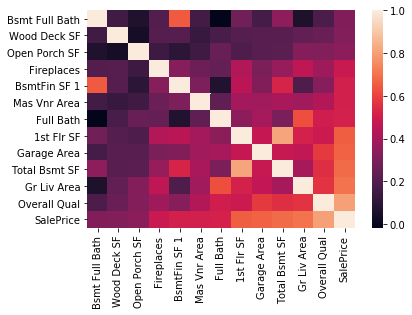

In [12]:
corr = numerical_train.corr()
sorted_corrs = corr["SalePrice"].apply(abs).sort_values()

import seaborn as sns
import matplotlib.pyplot as plt

strong_corrs = sorted_corrs[sorted_corrs >= 0.3]
#print(strong_corrs)

# we only select the numerical features that have a strong correlation with the SalePrice
num_cols = strong_corrs.index
print(strong_corrs.index)

corrmat = train[strong_corrs.index].corr()

sns.heatmap(corrmat)
plt.figure(figsize=(15,10))
plt.show()

#1st Floor SF and Total Bsmt SF are highly correlated
num_cols = num_cols.drop('Total Bsmt SF')

Among the remaining numerical columns we should check if they actually do have a semantic meaning and otherwise we should convert them to *categorical* columns.

In [13]:
num_cols

Index(['Bsmt Full Bath', 'Wood Deck SF', 'Open Porch SF', 'Fireplaces',
       'BsmtFin SF 1', 'Mas Vnr Area', 'Full Bath', '1st Flr SF',
       'Garage Area', 'Gr Liv Area', 'Overall Qual', 'SalePrice'],
      dtype='object')

In [14]:
print(len(num_cols))

12


#### Text columns

In [15]:
txt_cols = train.select_dtypes(include=['object'])

In [16]:
txt_cols.columns

Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Heating', 'Heating QC', 'Central Air', 'Electrical',
       'Kitchen Qual', 'Functional', 'Paved Drive'],
      dtype='object')

In [17]:

for col in txt_cols.columns:
    if len(txt_cols[col].unique()) > 10:
        print(col)
        txt_cols = txt_cols.drop(col,axis=1)
    

len(txt_cols.columns)

Neighborhood
Exterior 1st
Exterior 2nd


23

With a thresold equal to 10, we are dropping 3 text columns.

In [18]:
txt_cols['Functional'].value_counts()[0]/len(txt_cols)

0.93145990404386569

In [19]:
for col in txt_cols.columns:
    mf_uv = txt_cols[col].value_counts()[0]/len(txt_cols)
    if mf_uv >= 0.95:
        txt_cols = txt_cols.drop(col,axis=1)
len(txt_cols.columns)

17

When looking for columns that have almost a null variance (in the sense that more a unique value is repeated more than 95% for the same column), we can drop 6 other columns.

In [20]:
txt_cols = train.select_dtypes(include=['object'])

In [21]:
print(len(txt_cols.columns))

26


In [22]:
for col in txt_cols.columns:
    mf_uv = txt_cols[col].value_counts()[0]/len(txt_cols)
    if len(txt_cols[col].unique()) > 10 or mf_uv >= 0.95 :
        print(col)
        txt_cols = txt_cols.drop(col,axis=1)    

Street
Utilities
Land Slope
Neighborhood
Condition 2
Roof Matl
Exterior 1st
Exterior 2nd
Heating


In [23]:
txt_cols.columns

Index(['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Style', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual',
       'Functional', 'Paved Drive'],
      dtype='object')

In [24]:
print(len(txt_cols.columns))

17


In [25]:
train.shape

(1459, 56)

In [26]:
train.shape

(1459, 56)

In [36]:
dummy_cols = pd.DataFrame()
for col in txt_cols.columns:
    #print(col)
    train[col] = train[col].astype('category')
    col_dummies = pd.get_dummies(train[col])
    #print(col_dummies)
    train = pd.concat([train, col_dummies], axis=1)
    del train[col]

KeyError: 'MS Zoning'

Now let's summarize what we have done by updating the `select_features` function.

In [45]:
def transform_features(df_):
    df = df_.copy()
    # useless columns for ML 
    useless = ["PID","Order"]
    df = df.drop(useless,axis=1)
    # data leakage columns
    leak = ["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"]
    df = df.drop(leak,axis=1)
    
    # columns correlated to others
    cor_cols =['Garage Cars', 'TotRms AbvGrd']
    df = df.drop(cor_cols,axis=1)
    
    # new feature  
    df["years_until_remod"] = df["Year Remod/Add"] - df['Year Built']
    # dropping with negative value
    df = df.drop(df[df["years_until_remod"]<0].index[0],axis=0)
    # drop the columns not used anymore
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    # dropping all columns with more than 5% missing values
    mv = df.isnull().sum()/1460
    cols_mv = mv[mv >= 0.05].index
    df = df.drop(cols_mv,axis =1)
    
    # dropping all text columns with one more missing values
    mask_text = df.select_dtypes(include=['object']).isnull().sum() > 0
    cols_text_mv = mask_text[mask_text == True].index
    df = df.drop(cols_text_mv,axis=1)
    
    
    #filling missing values for numerical columns
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    col_num_mv = num_missing[num_missing > 0].index
    df[col_num_mv] = df[col_num_mv].fillna(df[col_num_mv].mode().iloc[0])

    #scaling the values
    #df = (df - df.min()) / (df.max()- df.min())
    
    return df

def select_features(df):
    
    
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.3].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df
    
def train_and_test(df):
    
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    train = df[:1460]
    test = df[1460:]
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = sklearn.metrics.mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    return rmse
    
                                       
                                

In [46]:
data = pd.read_csv("AmesHousing.txt", delimiter = "\t")
train = data[:1460]
print(train.shape)
test = data[1460:]
print(test.shape)


(1460, 82)
(1470, 82)


In [47]:
tf_data = transform_features(data)
sf_data = select_features(tf_data)

In [49]:
train_and_test(sf_data)

38014.8739391544

#### Here we reduced the RMSE from 57 000 to 38000 in comparison with the first basic model with only one feature

## Cross validation

>I used in this part the end of the **corrected** guided project that can be found [here](https://github.com/dataquestio/solutions/blob/master/Mission240Solutions.ipynb)


We update the `train_and_test` function so it handles the cross-validation.

In [50]:
def transform_features(df_):
    df = df_.copy()
    # useless columns for ML 
    useless = ["PID","Order"]
    df = df.drop(useless,axis=1)
    # data leakage columns
    leak = ["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"]
    df = df.drop(leak,axis=1)
    
    # columns correlated to others
    cor_cols =['Garage Cars', 'TotRms AbvGrd']
    df = df.drop(cor_cols,axis=1)
    
    # new feature  
    df["years_until_remod"] = df["Year Remod/Add"] - df['Year Built']
    # dropping with negative value
    df = df.drop(df[df["years_until_remod"]<0].index[0],axis=0)
    # drop the columns not used anymore
    df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)
    
    # dropping all columns with more than 5% missing values
    mv = df.isnull().sum()/1460
    cols_mv = mv[mv >= 0.05].index
    df = df.drop(cols_mv,axis =1)
    
    # dropping all text columns with one more missing values
    mask_text = df.select_dtypes(include=['object']).isnull().sum() > 0
    cols_text_mv = mask_text[mask_text == True].index
    df = df.drop(cols_text_mv,axis=1)
    
    
    #filling missing values for numerical columns
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    col_num_mv = num_missing[num_missing > 0].index
    df[col_num_mv] = df[col_num_mv].fillna(df[col_num_mv].mode().iloc[0])

    #scaling the values
    #df = (df - df.min()) / (df.max()- df.min())
    
    return df

def select_features(df):
    
    
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < 0.3].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

In [51]:
train_and_test(sf_data,k=3)

[34916.644021275919, 29341.915279627363, 32716.712499317717]


32325.090600073669